# <center>ASTR4004/8004 - Inference - Part 4</center> 

## Bayes' theorem:
$$
P(\theta|D)=P(D|\theta)\frac{P(\theta)}{P(D)}
$$

* $P(D|\theta)$: the likelihood function, representing the probability of observing the data ($D$) given a specific set of modeling parameters ($\theta$)
* $P(\theta)$: the prior probability distribution over the modeling parameters ($\theta$). This represents our initial beliefs of possible values of $\theta$
* $P(D)\equiv \sum \limits_{\theta} P(D,\theta)=\sum \limits_{\theta} P(D|\theta)P(\theta) = \int {\rm d}\theta P(\theta) P(D|\theta)$: the marginal likelihood or Bayesian evidence, representing the overall probability of observing the data (D)
* $P(\theta|D)$: the posterior probability distribution over the modeling parameters ($\theta$) given the data.

## Nested sampling
Let's re-write the likelihood as $\mathcal{L}(\theta)$ and prior as $\pi(\theta)$, we find the evidence becomes
$$
\mathcal{Z} = P(D) = \int {\rm d}\theta P(\theta) P(D|\theta) = \int_{\theta} {\rm d}\theta \pi(\theta) \mathcal{L}(\theta)
$$
We now define iso-likelihood contour, which encapsulates/nests samples in the prior volume ($X(\lambda)$) whose likelihoods are higher than $\lambda$:
$$
X(\lambda) = \int_{\mathcal{L}(\theta)>\lambda} \pi(\theta) {\rm d}\theta.
$$
Then the evidence becomes an intergral over the prior volume:
$$
\mathcal{Z} = \int_{0}^{1} {\rm d}X \mathcal{L}(X)
$$
If we can evaluate a series of iso-likelihood contour, $\mathcal{L}(X_{i})$ associated with a bunch of samples from the prior volume $1>X_{0}>X_{1}>...>X_{N}>0$, we can numerically compute the evidence using the standard trapezoid integration technique. Computing the evidence using these ''nested shells'' is what gives Nested Sampling its name.

Nested sampling methods typically rely on the generation of some live points, which are (randomly) uniformly distributed within the full prior volume. At each step $i$ of the algorithm, the live point with the lowest likelihood $\mathcal{L}_i$ is removed and a new point with $\mathcal{L}_{i+1} > \mathcal{L}_i$ is added. As each sample represents a changing prior volume (the nested shells), its weight when evaluating the evidence differs from points at other iteration: $w_{i+1} = X_{i} - X_{i+1}$.  

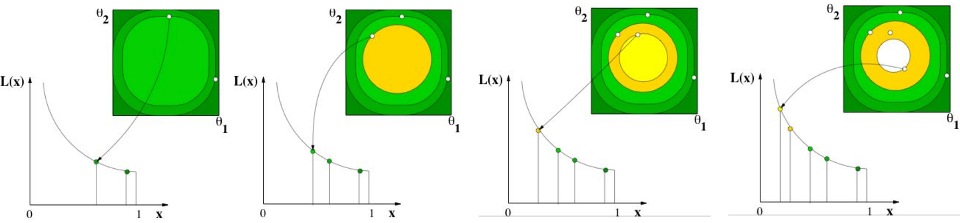

This notebook fits the correlation between input and output using the `dynesty` package, which also provides funtionalities to show the posterior.

## Useful packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import dynesty
from dynesty.utils import resample_equal
import corner

## Data (D) and the task
We will be given a dataset `(x, y)` and the task is to fit a linear function of `y=mx+b` to these data points.

Text(0, 0.5, 'y')

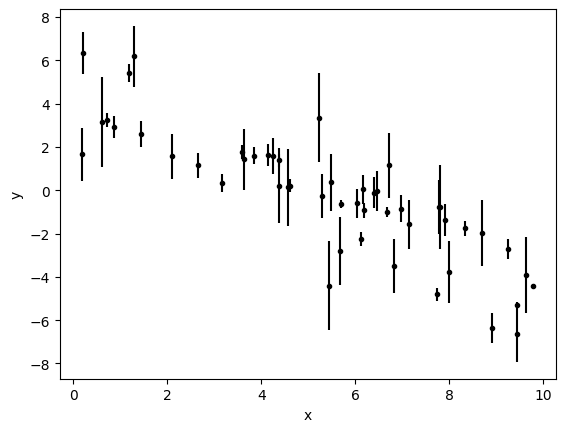

In [3]:
# Set seed for reproducibility
np.random.seed(0)

# Generate dataset (100 data points) following y = m * x +b
m_true = -0.9
b_true = 4.3
f_true = 0.5

n_data = 50
x = np.sort(10 * np.random.random(n_data)) # uniform random points between 0 and 10
yerr = 0.1 + 2.0 * np.random.random(n_data) # generate a uniform random error (standard deviation) between 0.1 and 5.1
y = m_true * x + b_true # array of exact y values correspond to x for the true parameters.
y += yerr * np.random.standard_normal(n_data) # perturb the exact y values according to yerr
y += np.abs(f_true * y) * np.random.standard_normal(n_data) #random noise that depends on y

plt.errorbar(x, y, yerr=yerr, fmt='k.')
plt.xlabel('x')
plt.ylabel('y')

## Propose your model
* It "seems" that our dataset $D$ follows a linear correlation.
* We also have some prior knowledge on the level of the error and know there is an error term which depends on `y` (e.g. thermal noise $\propto$ thermal energy)
* So we decide to fit it against a linear function of `y=mx+b`.
* We will also consider the extra error term ($\ln{f}$) when writing the likelihood.
* Therefore, out parameter $\theta$ corresponds to ($m$, $b$, $\ln{f}$).

## Define the prior of your model parametersm
Computationally live points in most nested sampling algorithms are generated over a N-dimensional unit hypercube (i.e. all axes range 0--1), and so rather than a lnprior function as in the `emcee` example, we typically define a prior transform that converts from a sample over U(0,1) into the required parameter space.

In [5]:
m_min, m_max = -5, 5
b_min, b_max = -10, 10
lnf_min, lnf_max = -6, 6

def prior_transform(unit_cube):
    """This function transforms from uniform samples drawn over the 
    interval from 0 to 1 into the model parameter space (theta). 
    
    In the example here all priors are uniform, but they don't necessarily
    have to be.
    """
    #first make a copy of the input unit hypercube
    params = np.array(unit_cube)
    
    #prior on m
    params[0] = unit_cube[0]*(m_max-m_min) + m_min
    
    #prior on b
    params[1] = unit_cube[1]*(b_max-b_min) + b_min
    
    #prior on f
    params[2] = unit_cube[2]*(lnf_max-lnf_min) + lnf_min

    return params

## Calculate the likelihood 

In [6]:
def lnlike(params, x, y, yerr):
    """
    This is the likelihood. This function takes in an array of parameters, 
    as well as the values from our data vector (in this case x, y, and 
    the error on y). It returns the total log(likelihood), i.e. p(D | theta).
    """
    #more complicated case
    m, b, lnf = params
    
    #our model for a line
    model = m * x + b
    sigma2 = yerr**2 + (np.exp(lnf)*model)**2

    return -0.5 * np.sum((y - model)**2 / sigma2 + np.log(sigma2))

## Bayesian inference

In [7]:
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf']
ndim        = 3 #number of dimensions (here it's 3: m, b and lnf)
num_samples = 400 #number of live points to sample the prior volume

# define the sampler
sampler = dynesty.NestedSampler(lnlike, prior_transform, ndim, nlive=num_samples,
                                logl_args=(x, y, yerr))

#run the sampler
sampler.run_nested()
# Extract sampling results.
results = sampler.results

5010it [00:02, 1724.33it/s, +400 | bound: 35 | nc: 1 | ncall: 28459 | eff(%): 19.281 | loglstar:   -inf < -39.586 <    inf | logz: -51.111 +/-  0.165 | dlogz:  0.001 >  0.409]


## resample with equal weight

In [8]:
samples = results.samples  
weights = np.exp(results.logwt)
np.random.seed(19)
# Resample weighted samples.
samples_equal = resample_equal(samples, weights)

/Users/vernica/Library/Python/3.13/lib/python/site-packages/dynesty/utils.py:1035: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")


## corner plot

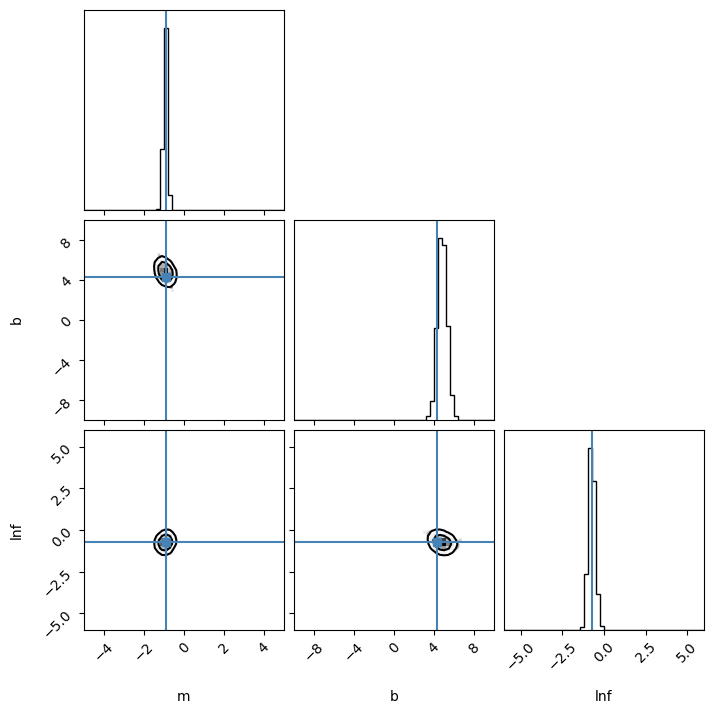

In [9]:
figure = corner.corner(samples_equal,
                       levels=[0, 0.68, 0.95],  # contour levels
                       color='k',alpha=1,      
                       truths=[m_true, b_true, np.log(f_true)], # show the truths 
                       labels=['m','b', 'lnf'],
                       range=((m_min,m_max),(b_min,b_max),(lnf_min, lnf_max)), bins=50, smooth=1)

## pick 100 random samples from the posterior and plot the model against data

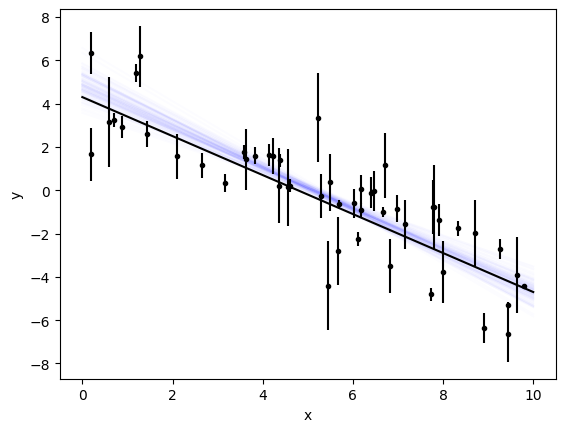

In [10]:
#overlay draws from the posterior
x_ref = np.linspace(0,10, 100)
inds = np.random.randint(samples_equal.shape[0], size=100)
for ind in inds:
    sample = samples_equal[ind]
    plt.plot(x_ref, sample[0]*x_ref + sample[1], "blue", alpha=0.01)
    
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_ref, m_true * x_ref + b_true, "k")
plt.xlabel('x')
plt.ylabel('y');